In [1]:
import pandas as pd
import numpy as np
import psycopg2 as pg
import matplotlib.pyplot as plt
import scipy.spatial.distance as distance
import ast
from sklearn.cluster import KMeans
from dotenv import dotenv_values
import matplotlib.patches as mpatches
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from scipy.special import kl_div, rel_entr

### Retrieve DF From Postgres Databse

In [2]:

# Load env variables
config = dotenv_values("../.env")
postgres_user = config["postgres_user"]
postgres_pw = config["postgres_pw"]

dtypes = {
    "id" : int,
    "vector" : object
}

#Connect to postgres and store data as df
engine = pg.connect(f"dbname='project_vector' user={postgres_user} host='127.0.0.1' port='5432' password={postgres_user}")
df = pd.read_sql('select * from my_vectors', columns=["ID" , "vector"] ,con=engine, dtype=dtypes)
df.columns

engine.close()


/tmp/ipykernel_58328/4279816448.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql('select * from my_vectors', columns=["ID" , "vector"] ,con=engine, dtype=dtypes)


### t-SNE

In [3]:
vector = df["vector"][0]
# Object (Vector Column) to List of Floats
df["vector"] = df["vector"].apply(lambda x: ast.literal_eval(x))


In [4]:
# Expand Vector to columns
df_vectors = pd.DataFrame(df["vector"].to_list() , columns=[ "danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "time_signature", "liked"])
# Scaling
df_vectors["duration_ms"] = df_vectors["duration_ms"]/ df_vectors["duration_ms"].max()
df_vectors["tempo"] = df_vectors["tempo"]/ df_vectors["tempo"].max()
df_vectors

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,liked
0,0.803,0.6240,7,-6.764,0,0.0477,0.4510,0.000734,0.1000,0.6280,0.533049,0.464771,4,0
1,0.762,0.7030,10,-7.951,0,0.3060,0.2060,0.000000,0.0912,0.5190,0.840549,0.377248,4,1
2,0.261,0.0149,1,-27.528,1,0.0419,0.9920,0.897000,0.1020,0.0382,0.418227,0.438006,4,0
3,0.722,0.7360,3,-6.994,0,0.0585,0.4310,0.000001,0.1230,0.5820,0.499122,0.318858,4,1
4,0.787,0.5720,1,-7.516,1,0.2220,0.1450,0.000000,0.0753,0.6470,0.861589,0.273824,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,0.166,0.0551,9,-19.494,0,0.0520,0.9760,0.635000,0.1190,0.1430,0.981004,0.315195,3,0
191,0.862,0.6240,3,-11.630,1,0.0565,0.0192,0.000153,0.0465,0.8820,0.693728,0.388026,4,0
192,0.499,0.3510,9,-11.509,0,0.0448,0.9510,0.000099,0.1180,0.6160,0.503588,0.360107,4,0
193,0.574,0.7290,10,-5.838,0,0.0965,0.0406,0.000004,0.1940,0.4130,0.614027,0.290347,5,1


In [5]:
# Scaling Dataframe
scaled_vectors = StandardScaler().fit_transform(df_vectors.values)

In [6]:
# Chat GPT generierte KL Divergenze Methode
def kl_divergenz_matrices(P, Q):
    # In Arrays umwandeln
    P = [np.array(p, dtype=np.float64) for p in P]
    Q = [np.array(q, dtype=np.float64) for q in Q]
    
    # Maximale Länge bestimmen
    max_len = max(max(len(p) for p in P), max(len(q) for q in Q))
    
    # Padding mit kleinem Wert für gleiche Länge
    P = [np.pad(p, (0, max_len - len(p)), constant_values=1e-10) for p in P]
    Q = [np.pad(q, (0, max_len - len(q)), constant_values=1e-10) for q in Q]
    
    # In numpy Arrays umwandeln
    P = np.array(P)
    Q = np.array(Q)
    
    # Jede Zeile in eine Wahrscheinlichkeitsverteilung umwandeln
    P /= P.sum(axis=1, keepdims=True)
    Q /= Q.sum(axis=1, keepdims=True)
    
    # KL-Divergenz zeilenweise berechnen
    kl_divs = np.sum(rel_entr(P, Q), axis=1)
    
    return kl_divs

In [7]:
# perform first t-SNE
X_embedded = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=3).fit_transform(scaled_vectors)

X_embedded.shape

(195, 2)

In [8]:
# Function to plot T-sne  (1dim, 2dim or 3 dim)
# Legend = KL Divergenz
def draw_tsne(perplexity=15, n_components=2, title=''):
    fit = TSNE(
        n_components=n_components,
        perplexity=perplexity       
    )
    u = fit.fit_transform(scaled_vectors);
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)))
        ax.legend(["%.4f" % fit.kl_divergence_])
        print(np.array(distance.pdist(u)).mean())
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1])
        ax.legend(["%.4f" % fit.kl_divergence_])
        print(np.array(distance.pdist(u)).mean())
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], s=100)
        ax.legend(["%.4f" % fit.kl_divergence_])
        print(np.array(distance.pdist(u)).mean())
    plt.title(title, fontsize=18)

58.065980058273844
48.948967522699036
38.2674276213021
34.131231774633896
29.158280020447002
19.330266509690397
13.321517291367899


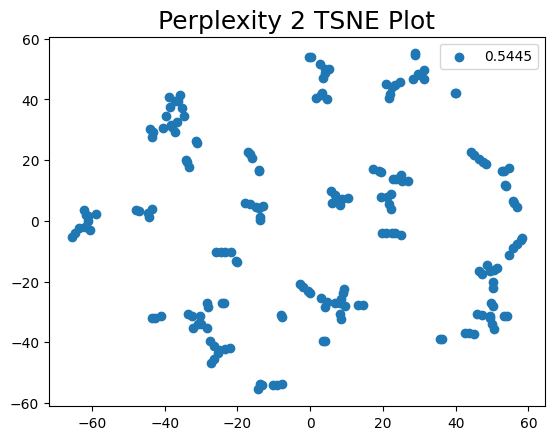

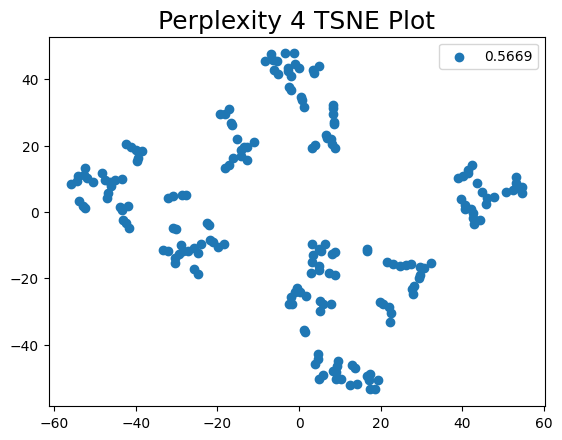

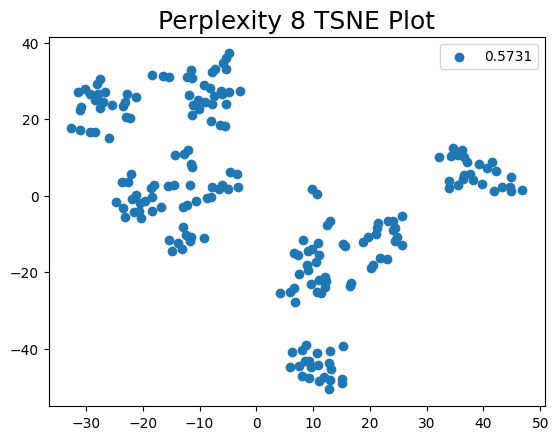

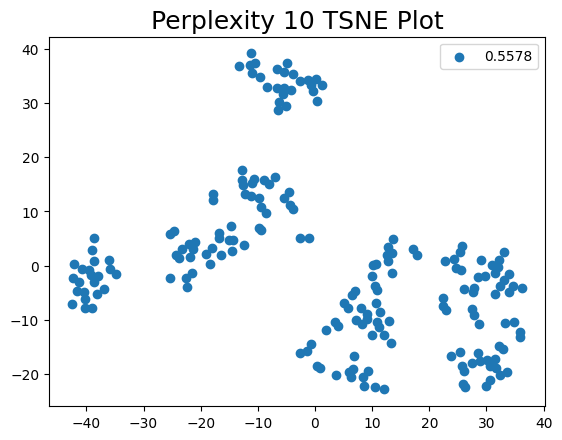

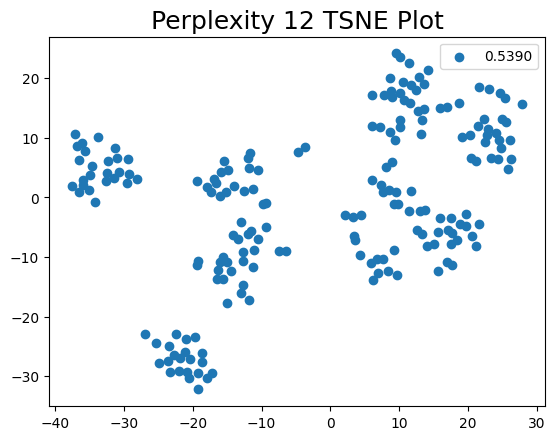

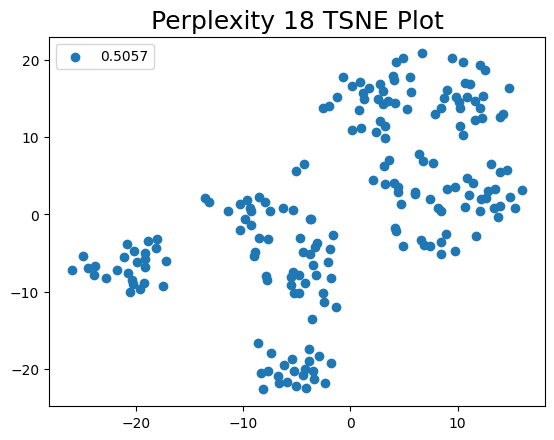

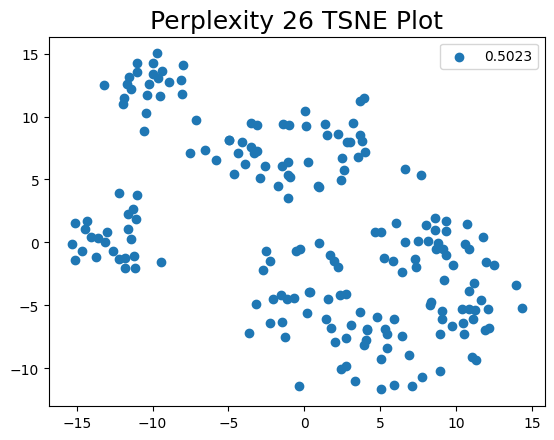

In [9]:
for perplexity in [2,4,8,10,12,18,26]:
    draw_tsne(perplexity=perplexity, n_components=2, title=f'Perplexity {perplexity} TSNE Plot')

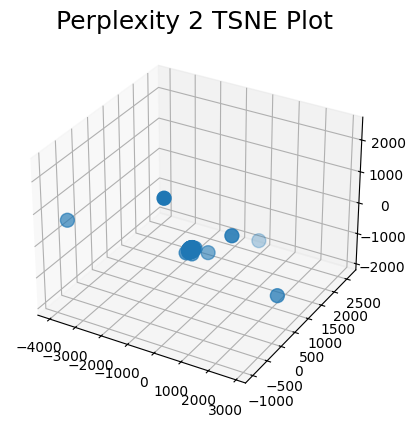

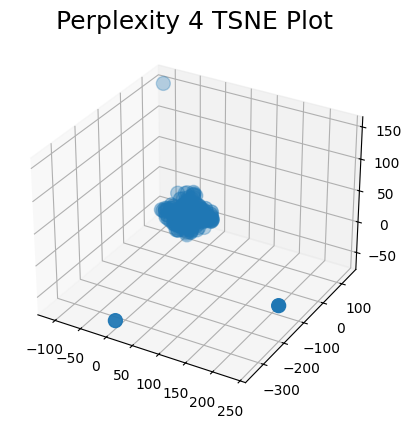

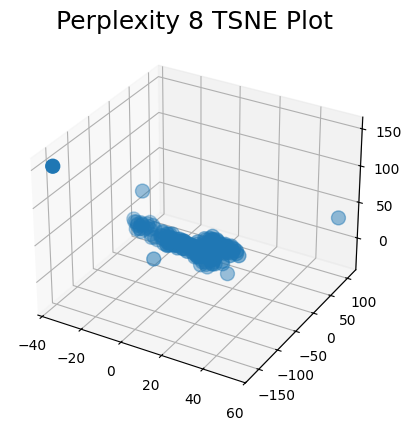

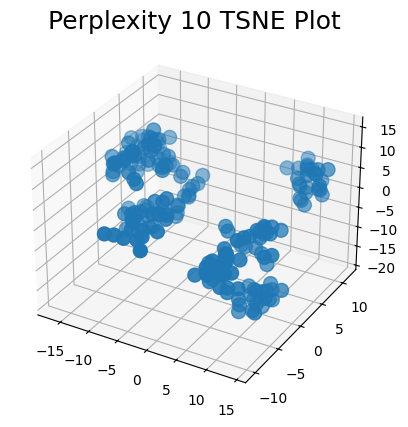

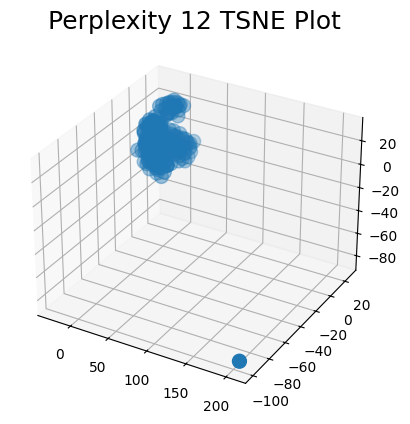

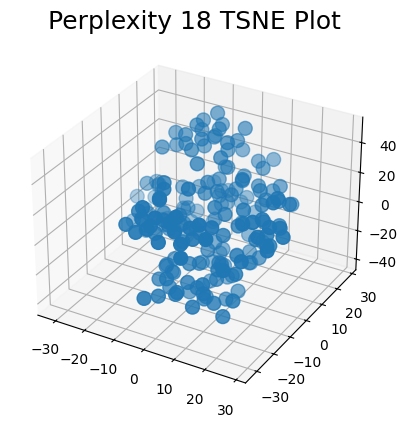

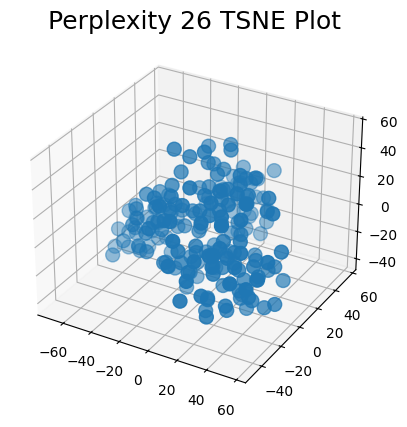

In [10]:
for perplexity in [2,4,8,10,12,18,26]:
    draw_tsne(perplexity=perplexity, n_components=3, title=f'Perplexity {perplexity} TSNE Plot')

In [11]:
# Function to get the avrg distance of each point to every other point
def avrg_distance_tsne(perplexity=15, n_components=2) -> float:
    fit = TSNE(
        n_components=n_components,
        perplexity=perplexity       
    )
    u = fit.fit_transform(scaled_vectors);
    return np.array(distance.pdist(u)).mean()

Text(0, 0.5, 'Average Distance')

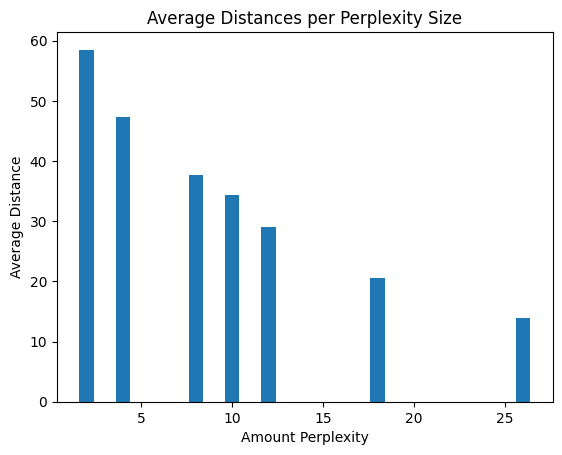

In [12]:
perplexities = [2,4,8,10,12,18,26]
average_distances :list[float] = []
for perplexity in perplexities:
    average_distances.append(avrg_distance_tsne(perplexity=perplexity, n_components=2))



plt.bar(perplexities , average_distances)
plt.title("Average Distances per Perplexity Size")
plt.xlabel("Amount Perplexity")
plt.ylabel("Average Distance")
    

### Perform Kmeans 

In [13]:
# Perform t-SNE with PP 10
fit = TSNE(
    n_components=2,
    perplexity=10       
)
u = fit.fit_transform(scaled_vectors);

## ellbow

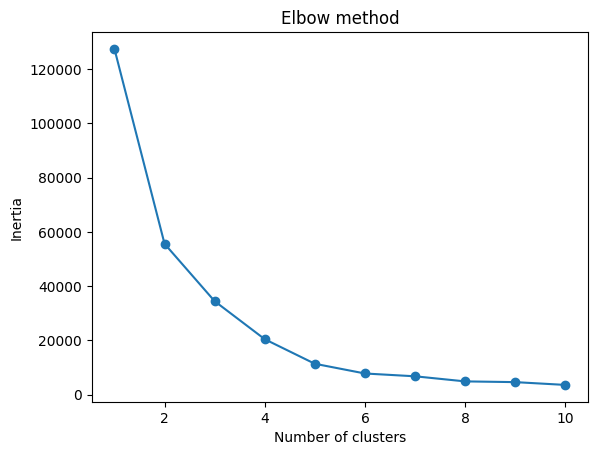

In [14]:
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(u)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show() 

In [15]:
# Perform k Means with 5 clusters
kmeans = KMeans(n_clusters=5, random_state=0, n_init="auto").fit(u)
kmeans.labels_

array([3, 4, 0, 4, 1, 1, 1, 1, 3, 1, 2, 1, 2, 1, 1, 3, 1, 3, 1, 1, 1, 3,
       4, 1, 4, 1, 4, 4, 1, 1, 4, 4, 2, 4, 3, 0, 3, 2, 3, 4, 2, 4, 4, 4,
       2, 2, 3, 1, 0, 2, 4, 1, 4, 3, 2, 1, 4, 1, 0, 2, 3, 4, 0, 4, 2, 4,
       4, 3, 1, 1, 1, 1, 4, 3, 1, 2, 2, 1, 4, 4, 1, 3, 4, 0, 1, 3, 0, 2,
       3, 3, 4, 3, 3, 3, 1, 3, 4, 3, 1, 1, 3, 1, 4, 2, 1, 3, 2, 0, 3, 1,
       0, 4, 1, 0, 2, 2, 3, 3, 1, 4, 4, 3, 4, 4, 1, 1, 2, 3, 3, 0, 3, 3,
       2, 1, 4, 0, 1, 3, 0, 1, 1, 1, 0, 1, 2, 3, 2, 4, 4, 1, 4, 3, 1, 2,
       3, 1, 4, 3, 0, 0, 4, 1, 4, 4, 3, 1, 1, 0, 0, 1, 0, 0, 1, 4, 3, 3,
       0, 1, 1, 1, 3, 1, 4, 2, 3, 3, 4, 4, 4, 2, 0, 3, 3, 4, 1],
      dtype=int32)

Text(0.5, 1.0, 'KMeans Cluster nach t-SNE Dimensionsreduktion')

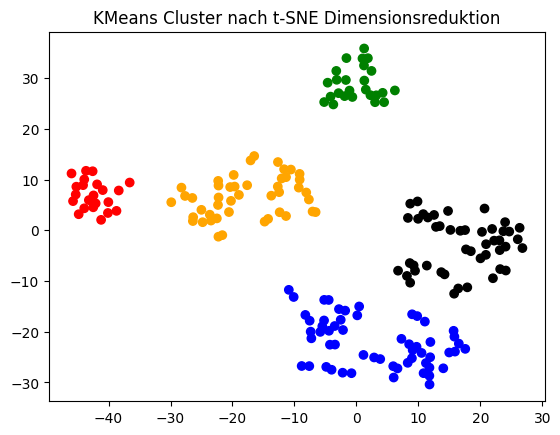

In [16]:
# Visualize Cluster in t-SNE Plot

fig = plt.figure()
ax = fig.add_subplot(111)
colors = kmeans.labels_
colors = colors.astype(str)
colors[colors == "0" ] = "red"
colors[colors == "1" ] = "blue"
colors[colors == "2" ] = "green"
colors[colors == "3" ] = "orange"
colors[colors == "4" ] = "black"

red_patch = mpatches.Patch(color='red', label='klassisch')
blue_patch = mpatches.Patch(color='blue', label='Pop')
green_patch = mpatches.Patch(color='green', label='Rock')
orange_patch = mpatches.Patch(color='orange', label='Soft Rock')
black_patch = mpatches.Patch(color='black', label='Rap')


ax.scatter(u[:,0], u[:,1], c=colors)
ax.set_title("KMeans Cluster nach t-SNE Dimensionsreduktion")

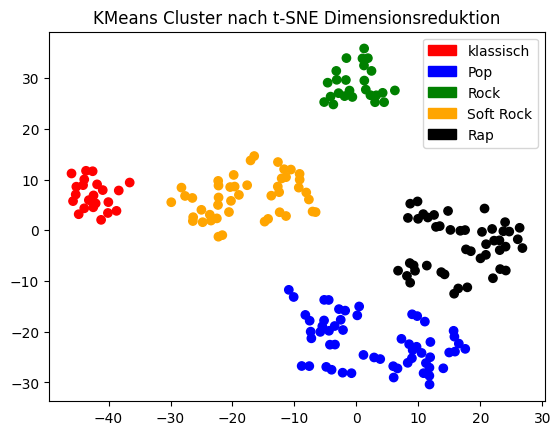

In [17]:
# Perform the same plot with music genres 


fig = plt.figure()
ax = fig.add_subplot(111)
colors = kmeans.labels_
colors = colors.astype(str)
colors[colors == "0" ] = "red"
colors[colors == "1" ] = "blue"
colors[colors == "2" ] = "green"
colors[colors == "3" ] = "orange"
colors[colors == "4" ] = "black"

red_patch = mpatches.Patch(color='red', label='klassisch')
blue_patch = mpatches.Patch(color='blue', label='Pop')
green_patch = mpatches.Patch(color='green', label='Rock')
orange_patch = mpatches.Patch(color='orange', label='Soft Rock')
black_patch = mpatches.Patch(color='black', label='Rap')


ax.scatter(u[:,0], u[:,1], c=colors)
ax.set_title("KMeans Cluster nach t-SNE Dimensionsreduktion")
ax.legend(handles=[red_patch , blue_patch, green_patch, orange_patch , black_patch])

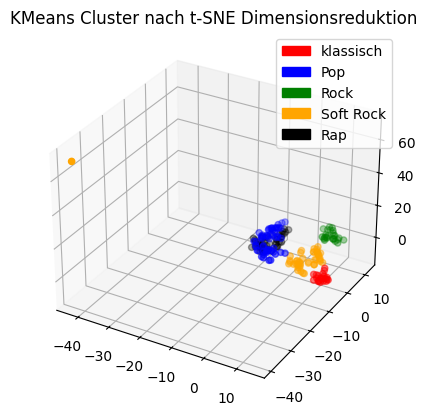

In [18]:
# 3 dimensional Plot of each Cluster

fit = TSNE(
    n_components=3,
    perplexity=10       
)

u = fit.fit_transform(scaled_vectors);

fig = plt.figure()

colors = kmeans.labels_
colors = colors.astype(str)
colors[colors == "0" ] = "red"
colors[colors == "1" ] = "blue"
colors[colors == "2" ] = "green"
colors[colors == "3" ] = "orange"
colors[colors == "4" ] = "black"

red_patch = mpatches.Patch(color='red', label='klassisch')
blue_patch = mpatches.Patch(color='blue', label='Pop')
green_patch = mpatches.Patch(color='green', label='Rock')
orange_patch = mpatches.Patch(color='orange', label='Soft Rock')
black_patch = mpatches.Patch(color='black', label='Rap')

ax = fig.add_subplot( projection='3d')
ax.scatter(u[:,0], u[:,1],  u[:,2], s=20, c=colors)
ax.set_title("KMeans Cluster nach t-SNE Dimensionsreduktion")
ax.legend(handles=[red_patch , blue_patch, green_patch, orange_patch , black_patch])

### Postgres Connection

In [19]:
# Load t-SNE Clusters into a table
conn = pg.connect(
    host="localhost", database="project_vector", user=postgres_user, password=postgres_pw
)
cur = conn.cursor()

cur.execute(
    f"""
    CREATE TABLE IF NOT EXISTS tsne_classes (
        id SERIAL PRIMARY KEY,
        class INTEGER NOT NULL
    )
"""
)
conn.commit()
cur.execute("delete from tsne_classes")
conn.commit()


classes = [(int(class_),) for class_ in kmeans.labels_]  
cur.executemany("INSERT INTO tsne_classes (class) VALUES (%s)", classes)

conn.commit()
cur.close()
conn.close()

print("Daten erfolgreich gespeichert!")


Daten erfolgreich gespeichert!
